Data source: https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction

##### Sample dataset

In [2]:
! hadoop fs -head /user/itv010025/Energy_consumption.csv

Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
2022-01-01 00:00:00,25.1394334377269,43.43158120480281,1565.6939992511175,5,On,Off,2.774698791658742,Monday,No,75.36437339539214
2022-01-01 01:00:00,27.731650520792968,54.225918580233085,1411.064918331917,1,On,On,21.831384152500608,Saturday,No,83.40185495035139
2022-01-01 02:00:00,28.704276857248125,58.907657743033184,1755.71500922237,2,Off,Off,6.76467168191291,Sunday,No,78.27088774061066
2022-01-01 03:00:00,20.080469485298178,50.3716371457499,1452.316318334375,1,Off,On,8.623446893471096,Wednesday,No,56.51985048548002
2022-01-01 04:00:00,23.09735925505204,51.40142134361278,1094.1303586981196,9,On,Off,3.0719692157166323,Friday,No,70.81173246793318
2022-01-01 05:00:00,29.576037393658908,36.82426323380886,1871.7091797360983,6,Off,Off,17.62668982389795,Sunday,Yes,84.32188519433718
2022-01-01 06:00:00,25.13116712267887,35.70962155267958,1607.0012284749637,6,On,O

#### Load the data to a dataframe

In [4]:
df=spark.read\
.format("csv")\
.option("header","true")\
.option("inferScehma","true")\
.load("/user/itv010025/Energy_consumption.csv")

### Analyze the average energy consumption on weekdays.

In [5]:
from pyspark.sql.functions import *

In [8]:
average_weekday_energy = df.filter(col("DayOfWeek").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday")) \
                           .groupBy("DayOfWeek") \
                           .agg({"EnergyConsumption": "avg"}) 

In [9]:
average_weekday_energy.show()

+---------+----------------------+
|DayOfWeek|avg(EnergyConsumption)|
+---------+----------------------+
|Wednesday|     77.36288506111985|
|  Tuesday|     76.52830062050926|
|   Friday|     76.86883595434503|
| Thursday|     77.36638317654781|
|   Monday|     77.44865209166277|
+---------+----------------------+



###  Renewable Energy Consumption on Weekends

In [16]:
renewable_energy_weekends = df.filter(col("DayOfWeek").isin("Saturday", "Sunday")) \
                              .groupBy("DayOfWeek") \
                              .agg({"RenewableEnergy": "sum"}) \

In [15]:
renewable_energy_weekends.show()

+---------+--------------------+
|DayOfWeek|sum(RenewableEnergy)|
+---------+--------------------+
| Saturday|   2229.131662346983|
|   Sunday|   2495.252659328652|
+---------+--------------------+



### Occupancy vs. Lighting Usage


In [17]:
occupancy_vs_lighting = df.groupBy("Occupancy", "LightingUsage") \
                         .count() \

In [18]:
occupancy_vs_lighting.show()

+---------+-------------+-----+
|Occupancy|LightingUsage|count|
+---------+-------------+-----+
|        2|          Off|   51|
|        9|          Off|   50|
|        6|           On|   53|
|        7|           On|   52|
|        3|          Off|   58|
|        4|          Off|   42|
|        7|          Off|   49|
|        5|           On|   52|
|        1|           On|   45|
|        9|           On|   43|
|        8|          Off|   65|
|        6|          Off|   54|
|        3|           On|   48|
|        8|           On|   53|
|        5|          Off|   44|
|        4|           On|   50|
|        0|           On|   50|
|        0|          Off|   48|
|        2|           On|   45|
|        1|          Off|   48|
+---------+-------------+-----+



### Analyzing Energy Consumption on Holidays

In [20]:
energy_consumption_holidays = df.filter(col("Holiday") == "Yes") \
                                .agg({"EnergyConsumption": "sum"}) \

In [21]:
energy_consumption_holidays.show()

+----------------------+
|sum(EnergyConsumption)|
+----------------------+
|     36215.26224385907|
+----------------------+



### Temperature Trends by Day of the Week

In [32]:
temperature_by_day = df.groupBy("DayOfWeek") \
                      .agg({"Temperature": "avg"}) \

In [33]:
temperature_by_day.show()

+---------+------------------+
|DayOfWeek|  avg(Temperature)|
+---------+------------------+
|Wednesday|24.962806681365343|
|  Tuesday| 24.72395318369506|
|   Friday|24.829071886394033|
| Thursday|24.941536839701246|
| Saturday|25.225067393433413|
|   Monday| 25.21602935941349|
|   Sunday|25.030861566988133|
+---------+------------------+



### Highest Energy Consumers

In [36]:
top_energy_consumers = df.orderBy("EnergyConsumption", ascending=False) \
                        .limit(5) 

In [37]:
top_energy_consumers.show()

+-------------------+------------------+------------------+------------------+---------+---------+-------------+------------------+---------+-------+-----------------+
|          Timestamp|       Temperature|          Humidity|     SquareFootage|Occupancy|HVACUsage|LightingUsage|   RenewableEnergy|DayOfWeek|Holiday|EnergyConsumption|
+-------------------+------------------+------------------+------------------+---------+---------+-------------+------------------+---------+-------+-----------------+
|2022-01-17 07:00:00|29.764203044712158|40.901013453169035| 1463.830142637306|        6|       On|           On|  15.3214993359711| Saturday|     No|99.20111959032309|
|2022-01-29 04:00:00|29.643731582141363| 43.95863614388401|1442.2749135624301|        8|      Off|           On| 27.17895038703294| Saturday|     No|98.84375583052464|
|2022-01-28 22:00:00|28.809743757906105|  31.2086057407159|1630.5279602661965|        6|       On|           On|19.352490458349166| Thursday|     No|98.76175414

### HVAC Usage during Working Hours

In [9]:
from pyspark.sql.types import *

In [10]:
# Converting 'Timestamp' column to timestamp type
df = df.withColumn("Timestamp", col("Timestamp").cast(TimestampType()))

In [45]:
# Filtering data for hours between 9 AM and 5 PM
working_hours_hvac = df.filter((hour("Timestamp") >= 9) & (hour("Timestamp") <= 17)) \
                      .groupBy("HVACUsage") \
                      .count() 

In [46]:
working_hours_hvac.show()

+---------+-----+
|HVACUsage|count|
+---------+-----+
|       On|  174|
|      Off|  202|
+---------+-----+



### Energy Consumption on Holidays vs. Non-Holidays

In [47]:
energy_comparison_holidays = df.groupBy("Holiday") \
                               .agg({"EnergyConsumption": "avg"}) \
                               .show()

+-------+----------------------+
|Holiday|avg(EnergyConsumption)|
+-------+----------------------+
|     No|      76.6240349434029|
|    Yes|     77.54874142153976|
+-------+----------------------+



### Lighting Usage on Weekdays

In [19]:
lighting_weekdays = df.filter(~col("DayOfWeek").isin("Saturday", "Sunday")) \
                     .groupBy("LightingUsage") \
                     .count() 

In [20]:
lighting_weekdays.show()

+-------------+-----+
|LightingUsage|count|
+-------------+-----+
|           On|  346|
|          Off|  357|
+-------------+-----+



### Occupancy Distribution on Weekends

In [21]:
occupancy_weekends = df.filter(col("DayOfWeek").isin("Saturday", "Sunday")) \
                     .groupBy("Occupancy") \
                     .count() 

In [22]:
occupancy_weekends.show()

+---------+-----+
|Occupancy|count|
+---------+-----+
|        7|   28|
|        3|   34|
|        8|   36|
|        0|   27|
|        5|   32|
|        6|   33|
|        9|   21|
|        1|   25|
|        4|   22|
|        2|   39|
+---------+-----+



### Renewable Energy Proportion

In [24]:
renewable_energy_proportion = df.agg({"RenewableEnergy": "sum", "EnergyConsumption": "sum"}) \
                             .withColumn("Proportion", col("sum(RenewableEnergy)") / col("sum(EnergyConsumption)")) 

In [25]:
renewable_energy_proportion.show()

+----------------------+--------------------+-------------------+
|sum(EnergyConsumption)|sum(RenewableEnergy)|         Proportion|
+----------------------+--------------------+-------------------+
|     77055.87286869274|  15132.812747962558|0.19638753263816333|
+----------------------+--------------------+-------------------+



### Average Square Footage per Occupancy Level

In [68]:
avg_sqft_per_occupancy = df.groupBy("Occupancy") \
                        .agg({"SquareFootage": "avg"}) 

In [69]:
avg_sqft_per_occupancy.show()

+---------+------------------+
|Occupancy|avg(SquareFootage)|
+---------+------------------+
|        7|1493.3113153485194|
|        3|1487.9264702094163|
|        8|1499.1131829727028|
|        0|1541.2384387610186|
|        5| 1484.001460270324|
|        6|1499.7132962204148|
|        9|1522.9972838625313|
|        1| 1445.975956809209|
|        4| 1533.936528078033|
|        2|1493.7602329103227|
+---------+------------------+



In [71]:
pip install matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.5 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 91.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 157.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 125.8 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 156.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Line Plot - Temperature Trends by Day

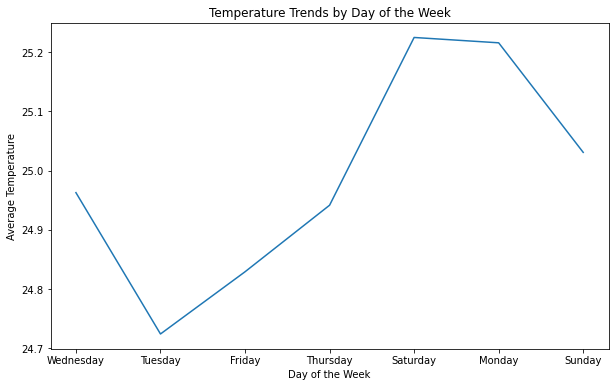

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

temperature_trends = df.groupBy("DayOfWeek") \
                      .agg({"Temperature": "avg"}) \
                      .toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x="DayOfWeek", y="avg(Temperature)", data=temperature_trends)
plt.title("Temperature Trends by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Temperature")
plt.show()

### Pie Chart - Distribution of Occupancy

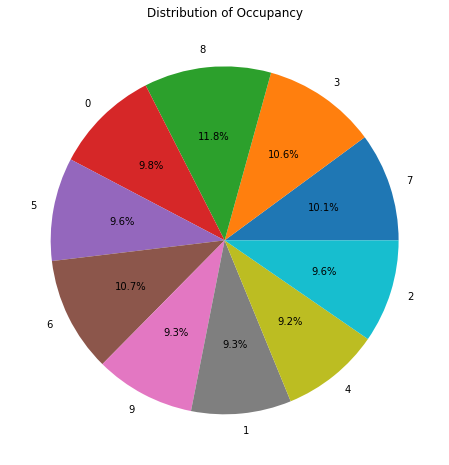

In [12]:
occupancy_distribution = df.groupBy("Occupancy") \
                          .count() \
                          .toPandas()

plt.figure(figsize=(8, 8))
plt.pie(occupancy_distribution["count"], labels=occupancy_distribution["Occupancy"], autopct='%1.1f%%')
plt.title("Distribution of Occupancy")
plt.show()